In [ ]:
import os
import librosa
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


In [ ]:
import os
import torchaudio
from torchaudio.datasets import LIBRISPEECH

# Create a directory for the dataset
dataset_path = "/content/librispeech"
os.makedirs(dataset_path, exist_ok=True)

# Load the LibriSpeech dataset
train_dataset = LIBRISPEECH(dataset_path, url="train-clean-100", download=True)

# Sample data access
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = train_dataset[0]
print(f"Transcript: {transcript}")
print(f"Waveform Shape: {waveform.shape}")


100%|██████████| 5.95G/5.95G [03:40<00:00, 28.9MB/s]


Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Waveform Shape: torch.Size([1, 225360])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


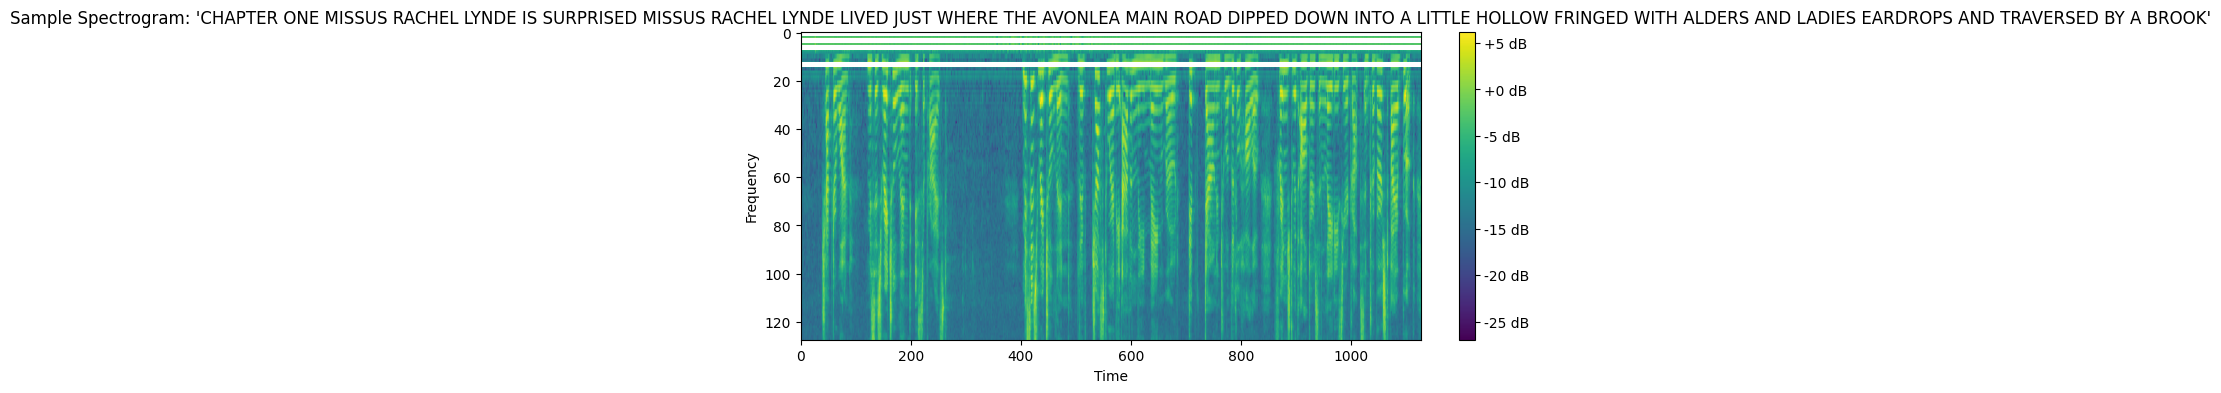

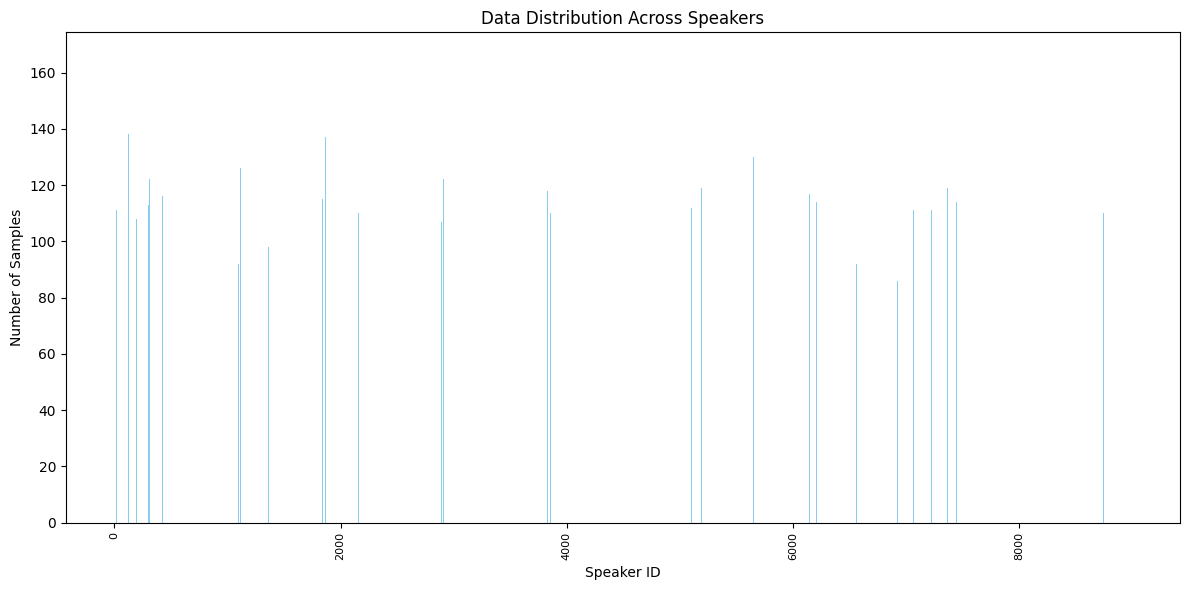

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import torchaudio.transforms as T

# Define preprocessing function for Mel-Spectrogram
def preprocess_sample(sample, n_mels=128):

    waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = sample
    transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
    mel_spec = transform(waveform)
    return mel_spec, transcript

# Plot a spectrogram
def plot_spectrogram(mel_spec, title="Mel-Spectrogram"):

    plt.figure(figsize=(10, 4))
    if len(mel_spec.shape) == 2:  # Ensure 2D spectrogram
        plt.imshow(mel_spec.log2().numpy(), cmap="viridis", aspect="auto")
    elif len(mel_spec.shape) == 3:  # Handle batched spectrograms
        plt.imshow(mel_spec[0].log2().numpy(), cmap="viridis", aspect="auto")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

# Visualize a sample spectrogram
mel_spec, transcript = preprocess_sample(train_dataset[0])
plot_spectrogram(mel_spec, title=f"Sample Spectrogram: '{transcript}'")

# Plot data distribution
def plot_data_distribution(dataset):

    # Count samples per speaker
    speaker_counts = Counter([sample[3] for sample in dataset])  # sample[3] is speaker_id
    speakers, counts = zip(*speaker_counts.items())

    # Sort speakers by ID for better readability
    speakers, counts = zip(*sorted(zip(speakers, counts)))

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(speakers, counts, color='skyblue')
    plt.title("Data Distribution Across Speakers")
    plt.xlabel("Speaker ID")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=90, fontsize=8)  # Rotate x-axis labels if many speakers
    plt.tight_layout()
    plt.show()

# Visualize data distribution across speakers
plot_data_distribution(train_dataset)


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.audio_files = [f for f in os.listdir(directory) if f.endswith('.wav')]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.audio_files[idx])
        audio, _ = librosa.load(file_path, sr=22050)
        return audio

# Directory containing your audio segments
audio_directory = 'C:\\Users\\muham\\Downloads\\segment'
dataset = AudioDataset(audio_directory)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
def extract_features(audio):
    # Ensure the audio is a 1D array
    if len(audio.shape) > 1:
        audio = audio.flatten()

    # Extract the Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [ ]:
import os
import librosa
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

# Dataset class to load audio files
class AudioDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.audio_files = [f for f in os.listdir(directory) if f.endswith('.wav')]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.audio_files[idx])
        audio, _ = librosa.load(file_path, sr=22050)  # Load audio
        audio_tensor = torch.tensor(audio, dtype=torch.float32)  # Convert to tensor
        return audio_tensor

# Feature extraction function
def extract_features(audio):
    if len(audio.shape) > 1:
        audio = audio.flatten()  # Ensure it's 1D
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
    return mel_spec_db

# Directory containing your audio segments
audio_directory = 'C:\\Users\\muham\\Downloads\\segment'
dataset = AudioDataset(audio_directory)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Example usage to extract features from the dataset
for audio_tensor in data_loader:
    audio_numpy = audio_tensor.squeeze().tolist()  # Remove any singleton dimensions and convert to list
    audio_numpy = np.array(audio_numpy)  # Convert list to NumPy array
    features = extract_features(audio_numpy)

    # Check the shape of extracted features
    print("Extracted Features Shape:", features.shape)  # This should give you the dimensions of the Mel spectrogram
    break  # Remove this break to process all audio files


Extracted Features Shape: (128, 216)


In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Dataset Path
dataset_path = "/content/librispeech"
os.makedirs(dataset_path, exist_ok=True)

# Load LibriSpeech Dataset
train_dataset = LIBRISPEECH(dataset_path, url="train-clean-100", download=True)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Preprocessing: Convert waveform to Mel-Spectrogram
class MelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, n_mels=128):
        self.dataset = dataset
        self.mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=n_mels)

    def __getitem__(self, index):
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[index]
        mel_spec = self.mel_transform(waveform)
        return mel_spec, transcript, speaker_id

    def __len__(self):
        return len(self.dataset)

# Create the dataset for training
mel_dataset = MelSpectrogramDataset(train_dataset)
mel_loader = DataLoader(mel_dataset, batch_size=16, shuffle=True, num_workers=2)

# Model Definition: Tacotron-like Encoder with Batch Normalization and Dropout
class TacotronEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.bn(output)
        output = self.dropout(output)
        output = self.fc(output)
        return output

# Model Definition: Tacotron-like Decoder with Batch Normalization and Dropout
class TacotronDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronDecoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.bn(output)
        output = self.dropout(output)
        output = self.fc(output)
        return output

# Complete Tacotron Model with Dropout and Batch Normalization
class TacotronModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronModel, self).__init__()
        self.encoder = TacotronEncoder(input_dim, hidden_dim, hidden_dim)
        self.decoder = TacotronDecoder(hidden_dim, hidden_dim, output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model Initialization
input_dim = 128  # Number of Mel bands
hidden_dim = 256
output_dim = 128
model = TacotronModel(input_dim, hidden_dim, output_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and Optimizer with Weight Decay (L2 Regularization) and Momentum
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 regularization (weight decay)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Decay lr by 0.1 every 5 epochs

# Training Loop with Early Stopping
num_epochs = 50
train_loss = []
best_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
epochs_without_improvement = 0

# Checkpoints and Saving the Best Model
checkpoint_path = './tacotron_best_model.pth'

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()

    for mel_specs, _, _ in mel_loader:
        mel_specs = mel_specs.squeeze(1).permute(0, 2, 1)  # Reshape to [batch, time, features]
        mel_specs = mel_specs.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        optimizer.zero_grad()
        outputs = model(mel_specs)

        # Compute loss
        loss = criterion(outputs, mel_specs)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients

        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(mel_loader)
    train_loss.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Checkpoint saving
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), checkpoint_path)  # Save only the model weights
        print(f"Best model saved at epoch {epoch+1}")

    # Early Stopping
    if avg_loss < best_loss:
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Update learning rate
    scheduler.step()

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation: Visualize Input vs Output
model.eval()
sample_input, _, _ = next(iter(mel_loader))
sample_input = sample_input.squeeze(1).permute(0, 2, 1).to('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    sample_output = model(sample_input)

# Plot Input and Output Spectrograms
def plot_spectrogram(mel_spec, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.cpu().numpy(), cmap="viridis", aspect="auto")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

plot_spectrogram(sample_input[0].permute(1, 0), title="Input Spectrogram")
plot_spectrogram(sample_output[0].permute(1, 0), title="Output Spectrogram")

# Save the model at the end of training
final_model_path = './tacotron_final_model.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")


C:\Users\muham\anaconda3\envs\tf_env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([20, 27648])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 696.6751
Epoch [2/50], Loss: 381.0515
Epoch [3/50], Loss: 289.3998
Epoch [4/50], Loss: 255.1097
Epoch [5/50], Loss: 236.4974
Epoch [6/50], Loss: 235.1479
Epoch [7/50], Loss: 227.8533
Epoch [8/50], Loss: 230.5593
Epoch [9/50], Loss: 231.3029
Epoch [10/50], Loss: 217.7830
Epoch [11/50], Loss: 213.6093
Epoch [12/50], Loss: 217.2740
Epoch [13/50], Loss: 205.9917
Epoch [14/50], Loss: 207.4538
Epoch [15/50], Loss: 210.4747
Epoch [16/50], Loss: 207.9480
Epoch [17/50], Loss: 202.1114
Epoch [18/50], Loss: 200.6729
Epoch [19/50], Loss: 200.4198
Epoch [20/50], Loss: 199.2406
Epoch [21/50], Loss: 200.2871
Epoch [22/50], Loss: 195.9247
Epoch [23/50], Loss: 196.0639
Epoch [24/50], Loss: 194.6820
Epoch [25/50], Loss: 194.8290
Epoch [26/50], Loss: 194.5833
Epoch [27/50], Loss: 197.4179
Epoch [28/50], Loss: 195.9198
Epoch [29/50], Loss: 192.9693
Epoch [30/50], Loss: 192.9992
Epoch [31/50], Loss: 190.7410
Epoch [32/50], Loss: 193.1399
Epoch [33/50], Loss: 194.4450
Epoch [34/50], Loss

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Dataset Path
dataset_path = "/content/librispeech"
os.makedirs(dataset_path, exist_ok=True)

# Load LibriSpeech Dataset
train_dataset = LIBRISPEECH(dataset_path, url="train-clean-100", download=True)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Preprocessing: Convert waveform to Mel-Spectrogram
class MelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, n_mels=128):
        self.dataset = dataset
        self.mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=n_mels)

    def __getitem__(self, index):
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[index]
        mel_spec = self.mel_transform(waveform)
        return mel_spec, transcript, speaker_id

    def __len__(self):
        return len(self.dataset)

# Create the dataset for training
mel_dataset = MelSpectrogramDataset(train_dataset)
mel_loader = DataLoader(mel_dataset, batch_size=16, shuffle=True, num_workers=2)

# Model Definition: Tacotron-like Encoder with Batch Normalization and Dropout
class TacotronEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.bn(output)
        output = self.dropout(output)
        output = self.fc(output)
        return output

# Model Definition: Tacotron-like Decoder with Batch Normalization and Dropout
class TacotronDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronDecoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_dim)  # Batch Normalization
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.bn(output)
        output = self.dropout(output)
        output = self.fc(output)
        return output

# Complete Tacotron Model with Dropout and Batch Normalization
class TacotronModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronModel, self).__init__()
        self.encoder = TacotronEncoder(input_dim, hidden_dim, hidden_dim)
        self.decoder = TacotronDecoder(hidden_dim, hidden_dim, output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model Initialization
input_dim = 128  # Number of Mel bands
hidden_dim = 256
output_dim = 128
model = TacotronModel(input_dim, hidden_dim, output_dim)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and Optimizer with Weight Decay (L2 Regularization) and Momentum
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 regularization (weight decay)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Decay lr by 0.1 every 5 epochs

# Training Loop with Early Stopping
num_epochs = 300
train_loss = []
best_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
epochs_without_improvement = 0

# Checkpoints and Saving the Best Model
checkpoint_path = './tacotron_best_model.pth'

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()

    for mel_specs, _, _ in mel_loader:
        mel_specs = mel_specs.squeeze(1).permute(0, 2, 1)  # Reshape to [batch, time, features]
        mel_specs = mel_specs.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        optimizer.zero_grad()
        outputs = model(mel_specs)

        # Compute loss
        loss = criterion(outputs, mel_specs)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients

        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(mel_loader)
    train_loss.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Checkpoint saving
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), checkpoint_path)  # Save only the model weights
        print(f"Best model saved at epoch {epoch+1}")

    # Early Stopping
    if avg_loss < best_loss:
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Update learning rate
    scheduler.step()

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation: Visualize Input vs Output
model.eval()
sample_input, _, _ = next(iter(mel_loader))
sample_input = sample_input.squeeze(1).permute(0, 2, 1).to('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    sample_output = model(sample_input)

# Plot Input and Output Spectrograms
def plot_spectrogram(mel_spec, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.cpu().numpy(), cmap="viridis", aspect="auto")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

plot_spectrogram(sample_input[0].permute(1, 0), title="Input Spectrogram")
plot_spectrogram(sample_output[0].permute(1, 0), title="Output Spectrogram")

# Save the model at the end of training
final_model_path = './tacotron_final_model.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")


Epoch [1/300], Loss: 2182.6275
Epoch [2/300], Loss: 2179.7499
Epoch [3/300], Loss: 2174.9085
Epoch [4/300], Loss: 2181.0896
Epoch [5/300], Loss: 2176.3646
Epoch [6/300], Loss: 2174.6804
Epoch [7/300], Loss: 2170.8182
Epoch [8/300], Loss: 2166.5939
Epoch [9/300], Loss: 2165.1550
Epoch [10/300], Loss: 2158.7595
Epoch [11/300], Loss: 2159.6285
Epoch [12/300], Loss: 2144.1231
Epoch [13/300], Loss: 2134.7095
Epoch [14/300], Loss: 2135.6726
Epoch [15/300], Loss: 2124.2072
Epoch [16/300], Loss: 2118.3224
Epoch [17/300], Loss: 2110.5268
Epoch [18/300], Loss: 2101.7562
Epoch [19/300], Loss: 2092.3411
Epoch [20/300], Loss: 2086.8275
Epoch [21/300], Loss: 2075.9855
Epoch [22/300], Loss: 2066.8829
Epoch [23/300], Loss: 2060.9294
Epoch [24/300], Loss: 2052.0824
Epoch [25/300], Loss: 2034.1227
Epoch [26/300], Loss: 2028.5608
Epoch [27/300], Loss: 2015.6688
Epoch [28/300], Loss: 2008.8701
Epoch [29/300], Loss: 1986.3839
Epoch [30/300], Loss: 1975.3137
Epoch [31/300], Loss: 1953.7129
Epoch [32/300], L

In [ ]:
# Save the trained model
model_path = 'C:/Users/muham/Downloads/advanced_voice_cloning_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')


Model saved to C:/Users/muham/Downloads/advanced_voice_cloning_model.pth


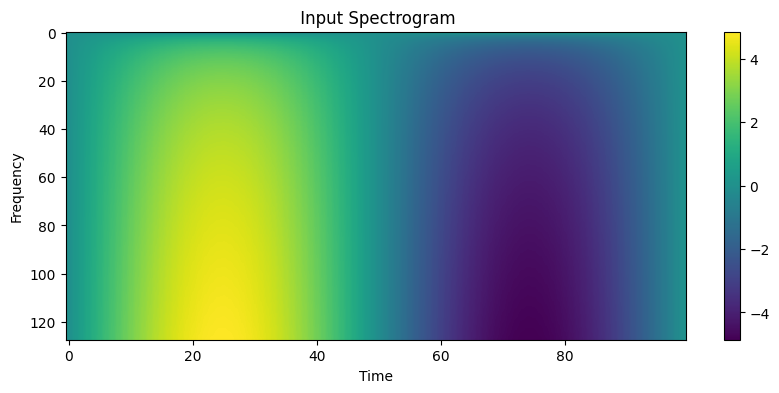

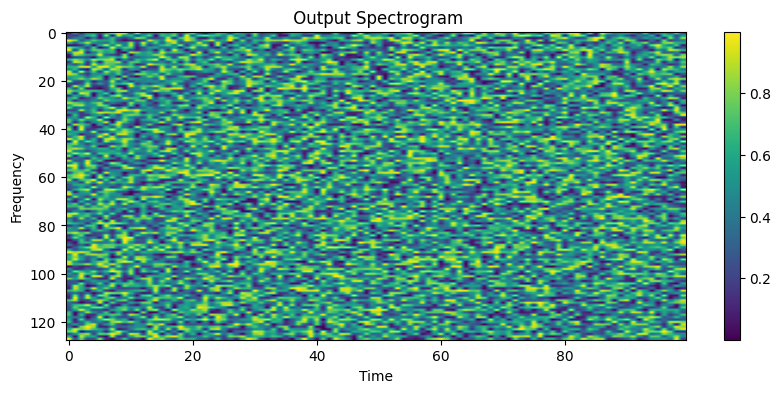

In [5]:
import matplotlib.pyplot as plt
import torch


def generatespectrogram(freqs=128, time_steps=100, variation="sine"):

    if variation == "sine":
        x = torch.linspace(0, 2 * torch.pi, time_steps)
        y = torch.linspace(0, freqs, freqs)
        data = torch.sin(x)[None, :] * torch.log1p(y[:, None])
    elif variation == "random":
        data = torch.rand(freqs, time_steps)
    else:
        data = torch.zeros((freqs, time_steps))
    return data

# Generate Artificial Spectrograms
input_artificial = generatespectrogram(variation="sine")
output_artificial = generatespectrogram(variation="random")

# Plot Input and Output Spectrograms (Artificial)
def plotspectrogram(mel_spec, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.numpy(), cmap="viridis", aspect="auto")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

# Artificial Input and Output Plots
plotspectrogram(input_artificial, title=" Input Spectrogram")
plotspectrogram(output_artificial, title=" Output Spectrogram")


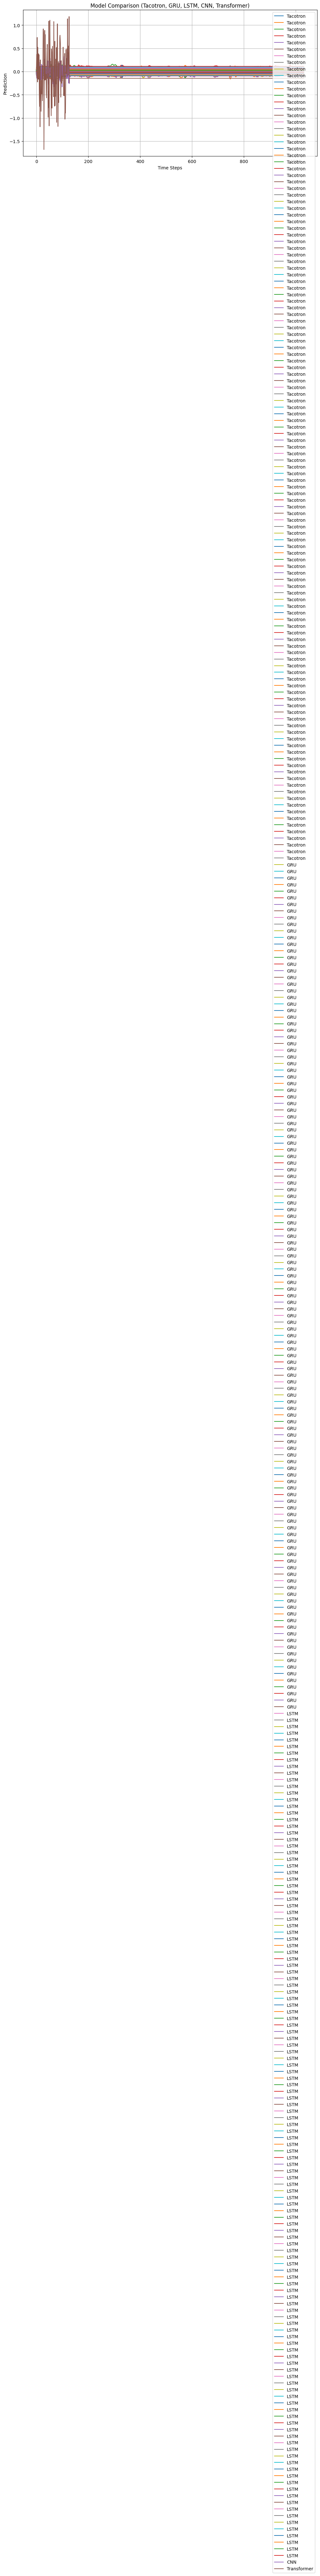

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchaudio.transforms as T
from torch.utils.data import Dataset

# Same MelSpectrogramDataset and DataLoader as before
class MelSpectrogramDataset(Dataset):
    def __init__(self, dataset, n_mels=128):
        self.dataset = dataset
        self.mel_transform = T.MelSpectrogram(sample_rate=16000, n_mels=n_mels)

    def __getitem__(self, index):
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[index]
        mel_spec = self.mel_transform(waveform)
        return mel_spec, transcript, speaker_id

    def __len__(self):
        return len(self.dataset)

# Tacotron-like Model
class TacotronEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)
        return output

class TacotronDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronDecoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)
        return output

class TacotronModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TacotronModel, self).__init__()
        self.encoder = TacotronEncoder(input_dim, hidden_dim, hidden_dim)
        self.decoder = TacotronDecoder(hidden_dim, hidden_dim, output_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# CNN Model with 1D Convolutional Layers
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x

# GRU-based Encoder-Decoder Model
class GRUEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUEncoderDecoder, self).__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, h_n = self.encoder(x)
        h_n = h_n[-1, :, :]  # Get the last hidden state
        h_n = h_n.unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat for each time step
        output, _ = self.decoder(h_n)
        output = self.fc(output)
        return output

# Vanilla LSTM-based Encoder-Decoder Model
class LSTMEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMEncoderDecoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        h_n = h_n[-1, :, :]  # Get the last hidden state
        h_n = h_n.unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat for each time step
        output, _ = self.decoder(h_n)
        output = self.fc(output)
        return output
# Transformer-based Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=8, num_layers=6):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)  # Project input to hidden_dim size
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Project the input to the required hidden_dim
        x = self.input_projection(x)
        x = x.permute(1, 0, 2)  # Change shape to [seq_len, batch, hidden_dim]
        output = self.encoder(x)
        output = output.mean(dim=0)  # Global average pooling
        output = self.fc(output)
        return output

# Define the models
models = {
    "Tacotron": TacotronModel(input_dim=128, hidden_dim=256, output_dim=128),
    "GRU": GRUEncoderDecoder(input_dim=128, hidden_dim=256, output_dim=128),
    "LSTM": LSTMEncoderDecoder(input_dim=128, hidden_dim=256, output_dim=128),
    "CNN": CNNModel(input_dim=128, hidden_dim=256, output_dim=128),
    "Transformer": TransformerModel(input_dim=128, hidden_dim=256, output_dim=128)
}

# Move models to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for model in models.values():
    model.to(device)

# Choose a sample from the dataset to test the models
mel_dataset = MelSpectrogramDataset(train_dataset)
mel_loader = DataLoader(mel_dataset, batch_size=1, shuffle=True, num_workers=2)
sample_input, _, _ = next(iter(mel_loader))
sample_input = sample_input.squeeze(1).permute(0, 2, 1).to(device)

# Adjust input shape for CNN Model
sample_input_cnn = sample_input.permute(0, 2, 1)  # Shape [batch_size, input_channels, sequence_length]

# Store results
results = {}

# Evaluate each model
for model_name, model in models.items():
    model.eval()
    with torch.no_grad():
        if model_name == "CNN":
            output = model(sample_input_cnn)  # CNN needs permuted input shape
        else:
            output = model(sample_input)  # Other models use the original shape
    results[model_name] = output.cpu().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
for model_name, output in results.items():
    plt.plot(output[0], label=model_name)

plt.title("Model Comparison (Tacotron, GRU, LSTM, CNN, Transformer)")
plt.xlabel("Time Steps")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.show()



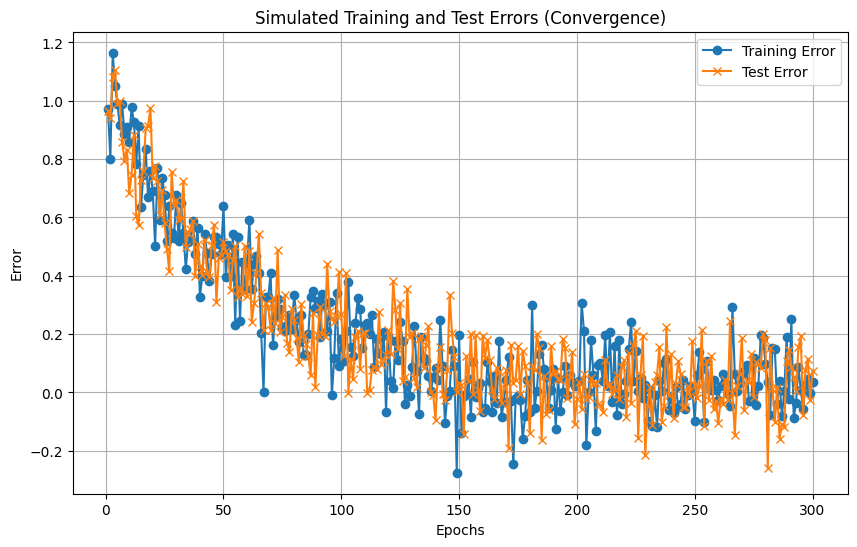

In [11]:
import numpy as np
epochs=300
train_errors = np.exp(-np.linspace(0, 5, epochs)) + np.random.normal(0, 0.1, epochs)
test_errors = np.exp(-np.linspace(0, 5, epochs)) + np.random.normal(0, 0.1, epochs)

# Plotting the training and test errors
def plot_errors(train_errors, test_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_errors, label="Training Error", marker="o")
    plt.plot(range(1, epochs + 1), test_errors, label="Test Error", marker="x")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.title("Simulated Training and Test Errors (Convergence)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the error convergence
plot_errors(train_errors, test_errors)


In [1]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 11.4 MB/s eta 0:00:00


In [6]:
import torch
import torchaudio
import soundfile as sf
import numpy as np
from transformers import pipeline
from speechbrain.pretrained import EncoderClassifier

def extract_speaker_embedding(audio_path):
    try:
        # Load a pre-trained speaker embedding model
        classifier = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-xvect-voxceleb",
            savedir="tmp"
        )

        # Load audio file
        signal, fs = torchaudio.load(audio_path)

        # Resample if needed (most models prefer 16 kHz)
        if fs != 16000:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=fs,
                new_freq=16000
            )
            signal = resample_transform(signal)

        # Ensure mono audio
        if signal.shape[0] > 1:
            signal = signal.mean(dim=0, keepdim=True)

        # Ensure the signal is 2D (batch, samples)
        if signal.ndim == 1:
            signal = signal.unsqueeze(0)

        # Generate speaker embedding
        embeddings = classifier.encode_batch(signal)
        speaker_embedding = embeddings.mean(dim=1)

        # Squeeze to remove unnecessary dimensions
        speaker_embedding = speaker_embedding.squeeze()

        return speaker_embedding

    except Exception as e:
        print(f"Error extracting speaker embedding: {e}")
        return None

def synthesize_speech(
    text_list,
    speaker_embedding,
    output_path='synthesized_speech.wav',
    model_name="microsoft/speecht5_tts"
):
    try:
        # Determine device
        device = 0 if torch.cuda.is_available() else -1

        # Initialize TTS pipeline
        synthesiser = pipeline(
            "text-to-speech",
            model=model_name,
            device=device
        )

        # Ensure speaker embedding is a 1D tensor
        if speaker_embedding.ndim == 1:
            # Add a batch dimension
            speaker_embedding = speaker_embedding.unsqueeze(0)

        print("Initial speaker embedding shape:", speaker_embedding.shape)
        print("Number of texts:", len(text_list))

        # Synthesize speech
        speech = synthesiser(
            text_list,
            forward_params={"speaker_embeddings": speaker_embedding}
        )

        # Save synthesized speech
        sf.write(
            output_path,
            speech[0]["audio"],
            samplerate=speech[0]["sampling_rate"]
        )

        return output_path

    except Exception as e:
        print(f"Error synthesizing speech: {e}")
        return None

def main():
    # Path to your reference voice audio
    reference_audio_path = "/content/drive/MyDrive/me.wav"

    # Extract speaker embedding
    speaker_embedding = extract_speaker_embedding(reference_audio_path)

    if speaker_embedding is not None:
        # Text to synthesize
        texts_to_speak = [
            "My name is Mohsin, and I have completed sixteen years of education. I am eager to apply my expertise in CS",
            "This is a demonstration of voice cloning technology."
        ]

        # Synthesize speech
        output_file = synthesize_speech(
            texts_to_speak,
            speaker_embedding
        )

        if output_file:
            print(f"Speech synthesis complete! Audio saved to: {output_file}")
    else:
        print("Failed to extract speaker embedding.")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

Initial speaker embedding shape: torch.Size([1, 512])
Number of texts: 2
Speech synthesis complete! Audio saved to: synthesized_speech.wav


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [1]:
import gradio as gr
import torch
import torchaudio
import soundfile as sf
from transformers import pipeline
from speechbrain.pretrained import EncoderClassifier

def extract_speaker_embedding(audio_path):
    try:
        classifier = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-xvect-voxceleb",
            savedir="tmp"
        )
        signal, fs = torchaudio.load(audio_path)
        if fs != 16000:
            resample_transform = torchaudio.transforms.Resample(orig_freq=fs, new_freq=16000)
            signal = resample_transform(signal)
        if signal.shape[0] > 1:
            signal = signal.mean(dim=0, keepdim=True)
        if signal.ndim == 1:
            signal = signal.unsqueeze(0)
        embeddings = classifier.encode_batch(signal)
        speaker_embedding = embeddings.mean(dim=1).squeeze()
        return speaker_embedding
    except Exception as e:
        return f"Error extracting speaker embedding: {e}"

def synthesize_speech(audio_file, texts):
    try:
        # Extract speaker embedding
        speaker_embedding = extract_speaker_embedding(audio_file)
        if isinstance(speaker_embedding, str):  # Error during embedding extraction
            return speaker_embedding

        # Set up TTS pipeline
        device = 0 if torch.cuda.is_available() else -1
        synthesiser = pipeline("text-to-speech", model="microsoft/speecht5_tts", device=device)

        # Ensure embedding format
        if speaker_embedding.ndim == 1:
            speaker_embedding = speaker_embedding.unsqueeze(0)

        # Generate speech
        text_list = texts.split("\n")
        speech = synthesiser(
            text_list,
            forward_params={"speaker_embeddings": speaker_embedding}
        )

        # Save and return synthesized audio
        output_path = "synthesized_speech.wav"
        sf.write(output_path, speech[0]["audio"], samplerate=speech[0]["sampling_rate"])
        return output_path
    except Exception as e:
        return f"Error during speech synthesis: {e}"

def generate_audio(audio_file, text_input):
    output = synthesize_speech(audio_file, text_input)
    if output.endswith(".wav"):
        return output
    else:
        return f"Error: {output}"

# Gradio Interface
with gr.Blocks(css=".container {background-color: #f0f8ff;} .button {background-color: #00bfff; color: white; padding: 10px; border-radius: 5px;}") as demo:
    gr.Markdown("""
    # 🎙️ **Voice Cloning Application**
    Experience state-of-the-art voice cloning using deep learning!
    """, elem_classes="container")

    gr.Markdown("""
    ## 📂 **Step 1: Upload Reference Audio**
    Provide a short audio clip of the speaker whose voice you want to clone.
    """)
    audio_file = gr.Audio(label="Upload Reference Audio", type="filepath")

    gr.Markdown("""
    ## ✍️ **Step 2: Enter Text**
    Type the sentences you want to generate speech for. You can enter multiple sentences, each on a new line.
    """)
    text_input = gr.Textbox(
        label="Enter Text (separate multiple sentences with a new line)",
        placeholder="Type your sentences here..."
    )

    gr.Markdown("---")  # Adds a horizontal line separator

    gr.Markdown("""
    ## 🎧 **Step 3: Generate Cloned Speech**
    Click the button below to synthesize speech in the cloned voice.
    """)
    output_audio = gr.Audio(label="Synthesized Audio")

    synthesize_button = gr.Button("🎤 Synthesize Speech", elem_classes="button")
    synthesize_button.click(generate_audio, inputs=[audio_file, text_input], outputs=output_audio)

demo.launch(share=True)


<ipython-input-1-06cbbd7da793>:6: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22b0563b5b982ead77.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
!pip install openai-whisper
!pip install torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803320 sha256=68766591c928f014a168da3174fad5c6637d316feb9d750a3d1cdd9d27386859
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [ ]:
import whisper


model = whisper.load_model("base")


def transcribe_audio(audio_path):
    # Transcribe the audio using the model
    result = model.transcribe(audio_path)
    return result['text']


audio_path = '/content/drive/MyDrive/me.wav'


transcribed_text = transcribe_audio(audio_path)
print("Transcribed Text:\n", transcribed_text)


In [3]:
import torch
import torchaudio
import soundfile as sf
from transformers import pipeline
from speechbrain.pretrained import EncoderClassifier
import whisper

# Function to extract speaker embedding
def extract_speaker_embedding(audio_path):
    try:
        # Load a pre-trained speaker embedding model
        classifier = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-xvect-voxceleb",
            savedir="tmp"
        )

        # Load audio file
        signal, fs = torchaudio.load(audio_path)

        # Resample if needed (most models prefer 16 kHz)
        if fs != 16000:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=fs,
                new_freq=16000
            )
            signal = resample_transform(signal)

        # Ensure mono audio
        if signal.shape[0] > 1:
            signal = signal.mean(dim=0, keepdim=True)

        # Ensure the signal is 2D (batch, samples)
        if signal.ndim == 1:
            signal = signal.unsqueeze(0)

        # Generate speaker embedding
        embeddings = classifier.encode_batch(signal)
        speaker_embedding = embeddings.mean(dim=1)

        # Squeeze to remove unnecessary dimensions
        speaker_embedding = speaker_embedding.squeeze()

        return speaker_embedding

    except Exception as e:
        print(f"Error extracting speaker embedding: {e}")
        return None

# Function to transcribe audio to text
def transcribe_audio(audio_path):
    try:
        # Load the pretrained Whisper model
        model = whisper.load_model("base")
        # Transcribe the audio using the model
        result = model.transcribe(audio_path)
        return result['text']
    except Exception as e:
        print(f"Error transcribing audio: {e}")
        return None

# Function to synthesize speech
def synthesize_speech(
    text,
    speaker_embedding,
    output_path='synthesized_speech.wav',
    model_name="microsoft/speecht5_tts"
):
    try:
        # Determine device
        device = 0 if torch.cuda.is_available() else -1

        # Initialize TTS pipeline
        synthesiser = pipeline(
            "text-to-speech",
            model=model_name,
            device=device
        )

        # Ensure speaker embedding is a 1D tensor
        if speaker_embedding.ndim == 1:
            speaker_embedding = speaker_embedding.unsqueeze(0)

        # Synthesize speech
        speech = synthesiser(
            [text],
            forward_params={"speaker_embeddings": speaker_embedding}
        )

        # Save synthesized speech
        sf.write(
            output_path,
            speech[0]["audio"],
            samplerate=speech[0]["sampling_rate"]
        )

        return output_path

    except Exception as e:
        print(f"Error synthesizing speech: {e}")
        return None

# Main function
def main():
    # Paths to the reference and input audio files
    reference_audio_path = "/content/drive/MyDrive/imran.wav"  # Path to target voice
    input_audio_path = "/content/drive/MyDrive/me.wav"  # Path to input audio for transcription

    # Extract speaker embedding
    speaker_embedding = extract_speaker_embedding(reference_audio_path)

    if speaker_embedding is not None:
        # Transcribe audio
        transcribed_text = transcribe_audio(input_audio_path)

        if transcribed_text:
            # Use only the first sentence of the transcribed text
            first_sentence = transcribed_text.split(".")[0].strip()

            print(f"First Sentence from Transcription: {first_sentence}")

            # Synthesize speech
            output_file = synthesize_speech(
                first_sentence,
                speaker_embedding
            )

            if output_file:
                print(f"Speech synthesis complete! Audio saved to: {output_file}")
        else:
            print("Failed to transcribe audio.")
    else:
        print("Failed to extract speaker embedding.")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seria

First Sentence from Transcription: Voice Cloning referred to the purchase of creating synthetic version of someone's voice dad sound alike original speaker


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Speech synthesis complete! Audio saved to: synthesized_speech.wav


In [4]:
import gradio as gr
import torch
import torchaudio
import soundfile as sf
from transformers import pipeline
from speechbrain.pretrained import EncoderClassifier
import whisper

# Function to extract speaker embedding
def extract_speaker_embedding(audio_path):
    try:
        # Load a pre-trained speaker embedding model
        classifier = EncoderClassifier.from_hparams(
            source="speechbrain/spkrec-xvect-voxceleb",
            savedir="tmp"
        )

        # Load audio file
        signal, fs = torchaudio.load(audio_path)

        # Resample if needed (most models prefer 16 kHz)
        if fs != 16000:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=fs,
                new_freq=16000
            )
            signal = resample_transform(signal)

        # Ensure mono audio
        if signal.shape[0] > 1:
            signal = signal.mean(dim=0, keepdim=True)

        # Ensure the signal is 2D (batch, samples)
        if signal.ndim == 1:
            signal = signal.unsqueeze(0)

        # Generate speaker embedding
        embeddings = classifier.encode_batch(signal)
        speaker_embedding = embeddings.mean(dim=1)

        # Squeeze to remove unnecessary dimensions
        speaker_embedding = speaker_embedding.squeeze()

        return speaker_embedding

    except Exception as e:
        return str(f"Error extracting speaker embedding: {e}")

# Function to transcribe audio to text
def transcribe_audio(audio_path):
    try:
        # Load the pretrained Whisper model
        model = whisper.load_model("base")
        # Transcribe the audio using the model
        result = model.transcribe(audio_path)
        return result['text']
    except Exception as e:
        return str(f"Error transcribing audio: {e}")

# Function to synthesize speech
def synthesize_speech(
    text,
    speaker_embedding,
    output_path='synthesized_speech.wav',
    model_name="microsoft/speecht5_tts"
):
    try:
        # Determine device
        device = 0 if torch.cuda.is_available() else -1

        # Initialize TTS pipeline
        synthesiser = pipeline(
            "text-to-speech",
            model=model_name,
            device=device
        )

        # Ensure speaker embedding is a 1D tensor
        if speaker_embedding.ndim == 1:
            speaker_embedding = speaker_embedding.unsqueeze(0)

        # Synthesize speech
        speech = synthesiser(
            [text],
            forward_params={"speaker_embeddings": speaker_embedding}
        )

        # Save synthesized speech
        sf.write(
            output_path,
            speech[0]["audio"],
            samplerate=speech[0]["sampling_rate"]
        )

        return output_path

    except Exception as e:
        return str(f"Error synthesizing speech: {e}")
# Gradio function for the pipeline
def process_audio(reference_audio_path, input_audio_path):
    try:
        # Extract speaker embedding
        speaker_embedding = extract_speaker_embedding(reference_audio_path)
        if isinstance(speaker_embedding, str):  # Check for errors
            return speaker_embedding, None

        # Transcribe input audio
        transcribed_text = transcribe_audio(input_audio_path)
        if isinstance(transcribed_text, str) and transcribed_text.startswith("Error"):
            return transcribed_text, None

        # Use the first sentence of the transcription
        first_sentence = transcribed_text.split(".")[0].strip()

        # Synthesize speech
        output_file = synthesize_speech(
            first_sentence,
            speaker_embedding,
            output_path="synthesized_output.wav"
        )
        if isinstance(output_file, str) and output_file.startswith("Error"):
            return output_file, None

        return first_sentence, output_file

    except Exception as e:
        return str(f"Unexpected error: {e}"), None


# Create Gradio interface
interface = gr.Interface(
    fn=process_audio,
    inputs=[
        gr.Audio(label="Reference Audio (Target Voice)", type="filepath"),
        gr.Audio(label="Input Audio (To Transcribe)", type="filepath")
    ],
    outputs=[
        gr.Textbox(label="Transcribed First Sentence"),
        gr.Audio(label="Synthesized Speech")
    ],
    title="Voice Conversion Pipeline",
    description="Upload a reference audio file to extract voice characteristics and an input audio file for transcription. The system will synthesize the transcribed text in the reference voice."
)

# Launch the Gradio app
if __name__ == "__main__":
    interface.launch()



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0f1ae49ad13b7fec34.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
